In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchinfo

# Imports

In [9]:
import torch
import torchvision
from torchvision.transforms import v2
import torchvision.transforms as transforms
import torchinfo
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import sys
import os
import pandas as pd
from collections import Counter
import seaborn as sn
from sklearn.metrics import confusion_matrix
import torchvision
import numpy as np
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm
import cv2
import math
import glob
from PIL import Image

import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Dataset, random_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# imports para as CNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

#sys.path.insert(1, '../../util') # Fernas
# sys.path.insert(1, '/content/drive/MyDrive/Mestrado/VCPI_Project/') # Cat
sys.path.insert(1, '/content/drive/MyDrive/VC/VCPI_Project/') # Martex
import vcpi_util

print(torch.__version__)

2.3.0+cu121


# Load data

In [10]:
# Definindo o dispositivo para treinamento
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Fernas
# DATASET_PATH = 'data'
# PNG_TRAIN_PATH = ''
# PNG_TEST_PATH = ''

# Cat
# DATASET_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/data'
# PNG_TRAIN_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/train_png'
# PNG_TEST_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/test_png'

# Marta
DATASET_PATH = '/content/drive/MyDrive/VC/VCPI_Project/data'
PNG_TRAIN_PATH = '/content/drive/MyDrive/VC/VCPI_Project/train_png'
PNG_TEST_PATH = '/content/drive/MyDrive/VC/VCPI_Project/test_png'


TRAIN_SET_PATH = DATASET_PATH + '/train_images/GTSRB/Final_Training/Images'
TEST_SET_PATH = DATASET_PATH + '/test_images'


IMG_SIZE = 64
NUM_CHANNELS = 3 # Pictures are in RGB
BATCH_SIZE = 32
NUM_CLASSES = 43
CLASS_NAMES = os.listdir(f'{DATASET_PATH}/test_images')
EPOCHS = 20

cpu


# Auxiliar Functions

In [12]:
def convert_images_to_png(dataset_path, output_base_path):
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.ppm'):
                try:
                    img = Image.open(os.path.join(root, file), mode='r')
                    base_name = os.path.basename(root)
                    class_folder = os.path.join(output_base_path, base_name)

                    os.makedirs(class_folder, exist_ok=True)

                    new_path = os.path.join(class_folder, file.replace('.ppm', '.png'))
                    img.save(new_path)

                except Exception as e:
                    print(f"Erro ao converter {file}: {e}")


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0

    for i, (images, targets) in enumerate(data_loader):

        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum
        # value of each row of the input tensor in the given dimension dim;
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


def train(model, data_loader, epochs, loss_fn, optimizer):

    # sets the model in training mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.train()

    history = {}
    history['accuracy'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        start_time = time.time()
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(data_loader, 0):

            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)

            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Accuracy = {accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')

    return(history)


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(dataset.dataset.classes))


def prepare_callbacks(path):
    checkpointer = ModelCheckpoint(filepath= path,
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 10, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=5,
                                 mode='auto',
                                 min_lr=0.000000001,
                                 verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]


def show_batch(image_batch, label_batch):
    rows = 3
    columns = 10

    fig, axs = plt.subplots(rows, columns, figsize=(10, 6*rows))
    fig.suptitle('Batch images with classes names', fontsize=16)

    for r in range(rows):
        for c in range(columns):
            # Calculate the index for the current image in the batch
            index = r * columns + c

            # Check if the end of the batch has reached
            if index >= len(image_batch):
                break

            # Display the image
            axs[r, c].imshow(image_batch[index])
            axs[r, c].axis('off')  # Hide axes

            # Set title based on the label
            label_index = np.where(label_batch[index] == 1)[0][0]
            axs[r, c].set_title(CLASS_NAMES[label_index], fontsize=8)

    plt.show()

# Converter imagens para .png

In [13]:
# Definindo os caminhos relativos ao diretório atual de trabalho
BASE_DIR = os.path.abspath('.')
# PNG_TRAIN_PATH = os.path.join(BASE_DIR, 'train_png')
# PNG_TEST_PATH = os.path.join(BASE_DIR, 'test_png')

# DATASET_PATH = os.path.join(BASE_DIR, 'data')
# TRAIN_SET_PATH = os.path.join(DATASET_PATH, 'train_images', 'GTSRB', 'Final_Training', 'Images')
# TEST_SET_PATH = os.path.join(DATASET_PATH, 'test_images', 'GTSRB', 'Final_Test', 'Images')

# Imprima os caminhos para verificar se estão corretos
print("BASE_DIR:", BASE_DIR)
print("TRAIN_SET_PATH:", TRAIN_SET_PATH)
print("TEST_SET_PATH:", TEST_SET_PATH)
print("PNG_TRAIN_PATH:", PNG_TRAIN_PATH)
print("PNG_TEST_PATH:", PNG_TEST_PATH)

# Verifique se as pastas existem
assert os.path.exists(TRAIN_SET_PATH), f"Path does not exist: {TRAIN_SET_PATH}"
assert os.path.exists(TEST_SET_PATH), f"Path does not exist: {TEST_SET_PATH}"

# Converta as imagens antes de carregar o conjunto de dados
#convert_images_to_png(TRAIN_SET_PATH, PNG_TRAIN_PATH)
#convert_images_to_png(TEST_SET_PATH, PNG_TEST_PATH)

BASE_DIR: /content
TRAIN_SET_PATH: /content/drive/MyDrive/VC/VCPI_Project/data/train_images/GTSRB/Final_Training/Images
TEST_SET_PATH: /content/drive/MyDrive/VC/VCPI_Project/data/test_images
PNG_TRAIN_PATH: /content/drive/MyDrive/VC/VCPI_Project/train_png
PNG_TEST_PATH: /content/drive/MyDrive/VC/VCPI_Project/test_png


# Modelo CNN

## Model_I - Sem augmentation

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PNG_TRAIN_PATH,
    batch_size = None,
    label_mode = 'categorical',
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True
  )
normalize = tf.keras.layers.Rescaling(1.0/255)
dataset = dataset.map(lambda x, y: (normalize(x), y))


test_loader = tf.keras.preprocessing.image_dataset_from_directory(
    PNG_TEST_PATH,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    shuffle = False
  )
test_loader = test_loader.map(lambda x, y: (normalize(x), y))

total_size = dataset.cardinality().numpy()
train_size = total_size * 0.8
train_loader = dataset.take(int(train_size))
val_loader = dataset.skip(int(train_size))
print(f'Train Size: {int(train_size)}\nValidation Size: {int(total_size - train_size)}')

Found 33911 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.
Train Size: 27128
Validation Size: 6782


In [15]:
total_size = dataset.cardinality().numpy()
train_set = dataset.take(int(total_size * 0.8))
val_set = dataset.skip(int(total_size * 0.8))

In [16]:
images = next(iter(train_set))
print(images[0].shape, images[1].shape)

dataset_length = train_set.cardinality().numpy()
print("Total images in dataset: ", dataset_length)

(64, 64, 3) (43,)
Total images in dataset:  27128


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.map(lambda image, label: (tf.image.resize(image, [IMG_SIZE,IMG_SIZE]),label), num_parallel_calls= AUTOTUNE)
val_set = val_set.map(lambda image, label: (tf.image.resize(image, [IMG_SIZE,IMG_SIZE]),label), num_parallel_calls= AUTOTUNE)

In [18]:
data = train_set
data = data.cache()
data = data.prefetch(buffer_size=10200)
data = data.batch(batch_size=BATCH_SIZE)

In [19]:
val_set = val_set.cache()
val_set = val_set.batch(batch_size = 2580)
val_set = val_set.prefetch(buffer_size = AUTOTUNE)

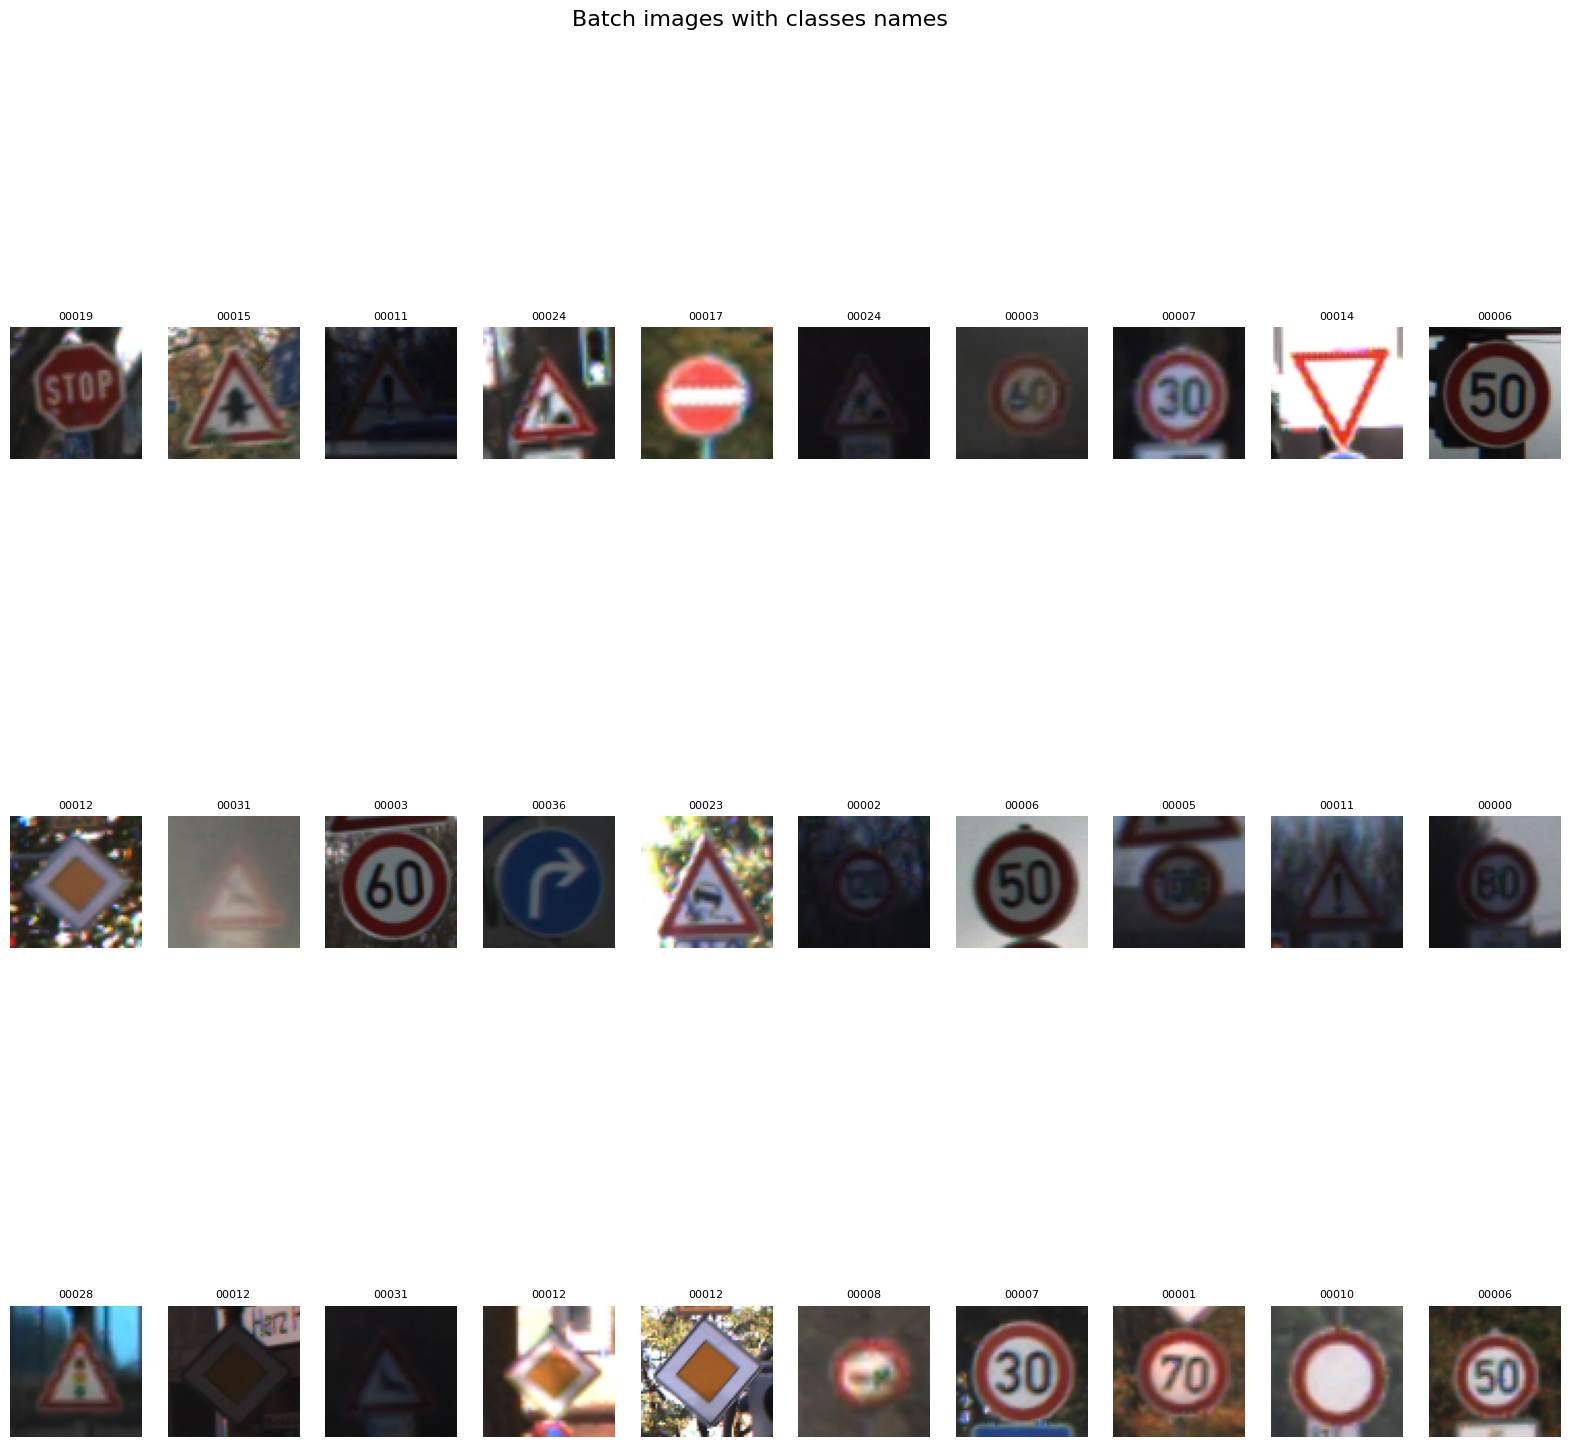

In [20]:
image_batch, label_batch = next(iter(data))
show_batch(image_batch, label_batch.numpy())

In [21]:
def model_I(numClasses, imgSize, channels):

    model = Sequential()

    model.add(Conv2D(128, (5, 5), input_shape=(imgSize, imgSize, channels)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (5, 5) ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (5, 5) ) )
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))

    model.add(Dense(numClasses, activation='softmax'))

    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

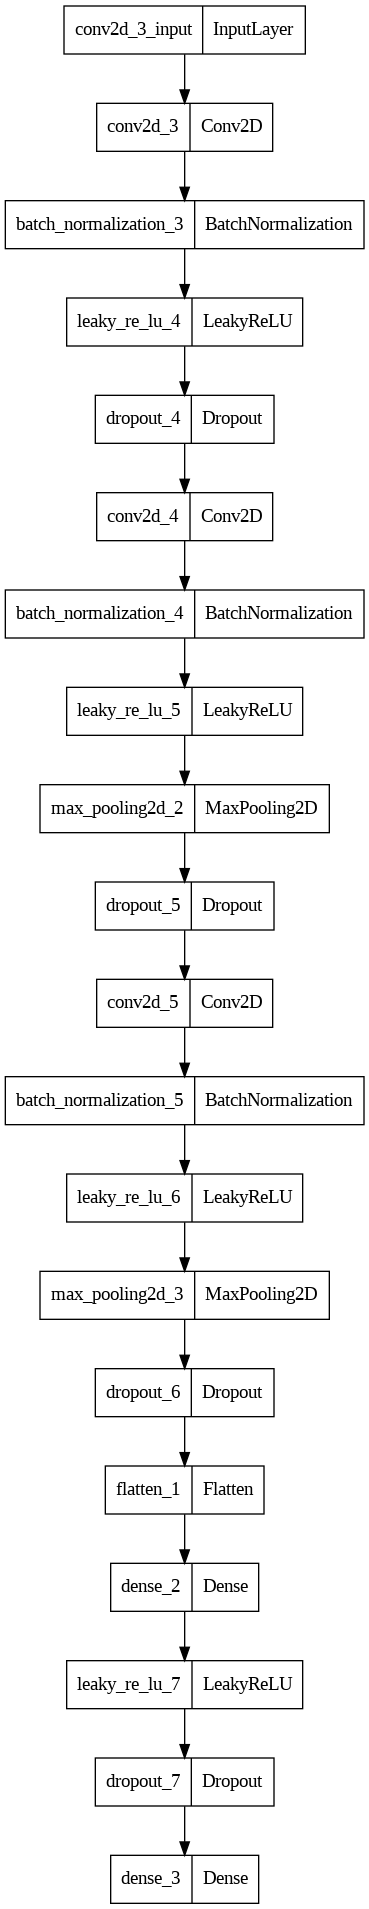

In [23]:
modelV1 = model_I(NUM_CLASSES, IMG_SIZE, 3)
plot_model(modelV1)

In [ ]:
file_pathV1 = f'{DATASET_PATH}/V1/cp.ckpt'
callbacksV1 = prepare_callbacks(file_pathV1)

historyV1 = modelV1.fit(
        data,
        epochs = EPOCHS,
        validation_data = val_set,
        callbacks = callbacksV1
      )

Epoch 1/20
234/848 [=======>......................] - ETA: 3:56:26 - loss: 4.3099 - accuracy: 0.1226

---------------------------------------

# este codigo aqui em baixo foi para testar... o que esta em cima é o correto

In [57]:
# Cat
# PNG_TRAIN_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/train_png'
# PNG_TEST_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/test_png'

# Marta
PNG_TRAIN_PATH = '/content/drive/MyDrive/VC/VCPI_Project/train_png'
PNG_TEST_PATH = '/content/drive/MyDrive/VC/VCPI_Project/test_png'


# Load the training and testing datasets
train_loader = tf.keras.utils.image_dataset_from_directory(directory=PNG_TRAIN_PATH, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=True, label_mode='categorical', follow_links=True)
test_loader = tf.keras.utils.image_dataset_from_directory(directory=PNG_TEST_PATH, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical')

class_names = train_loader.class_names

# Calculate the total number of images in the training set
total_train_images = len(train_loader) * BATCH_SIZE
print(f'Total Train Images: {total_train_images}')

# Now, you can proceed with your calculations knowing the total number of images
total_train_samples = total_train_images
print(f'Total Train Samples: {total_train_samples}')

# Divide the data based on the number of samples
train_size = int(total_train_samples * 0.8)
val_size = total_train_samples - train_size

# Create new iterators for training and validation
train_loader = train_loader.take(train_size)
val_loader = train_loader.skip(train_size)

# Print the sizes of the training and validation sets
print(f'Train Size: {train_size}\nValidation Size: {val_size}')

Found 33911 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.
Total Train Images: 33920
Total Train Samples: 33920
Train Size: 27136
Validation Size: 6784


In [30]:
# For the training set
train_images, train_targets = next(iter(train_loader))
print("Training Set:")
# Putting color channel last so that the image can be displayed
if len(train_images.shape) == 4 and train_images.shape[-1]!= 3:
    test_images = np.transpose(train_images, (0, 2, 3, 1))
print("Batch shape:", train_images.shape)
print(f"Targets: {train_targets}")
print("Training set batches:", train_loader.cardinality().numpy())

Training Set:
Batch shape: (32, 64, 64, 3)
Targets: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Training set batches: 1060


In [31]:
# For the test set
test_images, test_targets = next(iter(test_loader))
test_images = test_images / 255.0
print("\nTest Set:")
print("Batch shape:", test_images.shape)
test_images = test_images.numpy()
print("Each image varies between", np.min(test_images), "and", np.max(test_images))
# Putting color channel last so that the image can be displayed
if len(test_images.shape) == 4 and test_images.shape[-1]!= 3:
    test_images = np.transpose(test_images, (0, 2, 3, 1))
print("Shape after channel transpose:", test_images.shape)
print("Test set batches:", test_loader.cardinality().numpy())


Test Set:
Batch shape: (32, 64, 64, 3)
Each image varies between 0.006617647 and 1.0
Shape after channel transpose: (32, 64, 64, 3)
Test set batches: 395


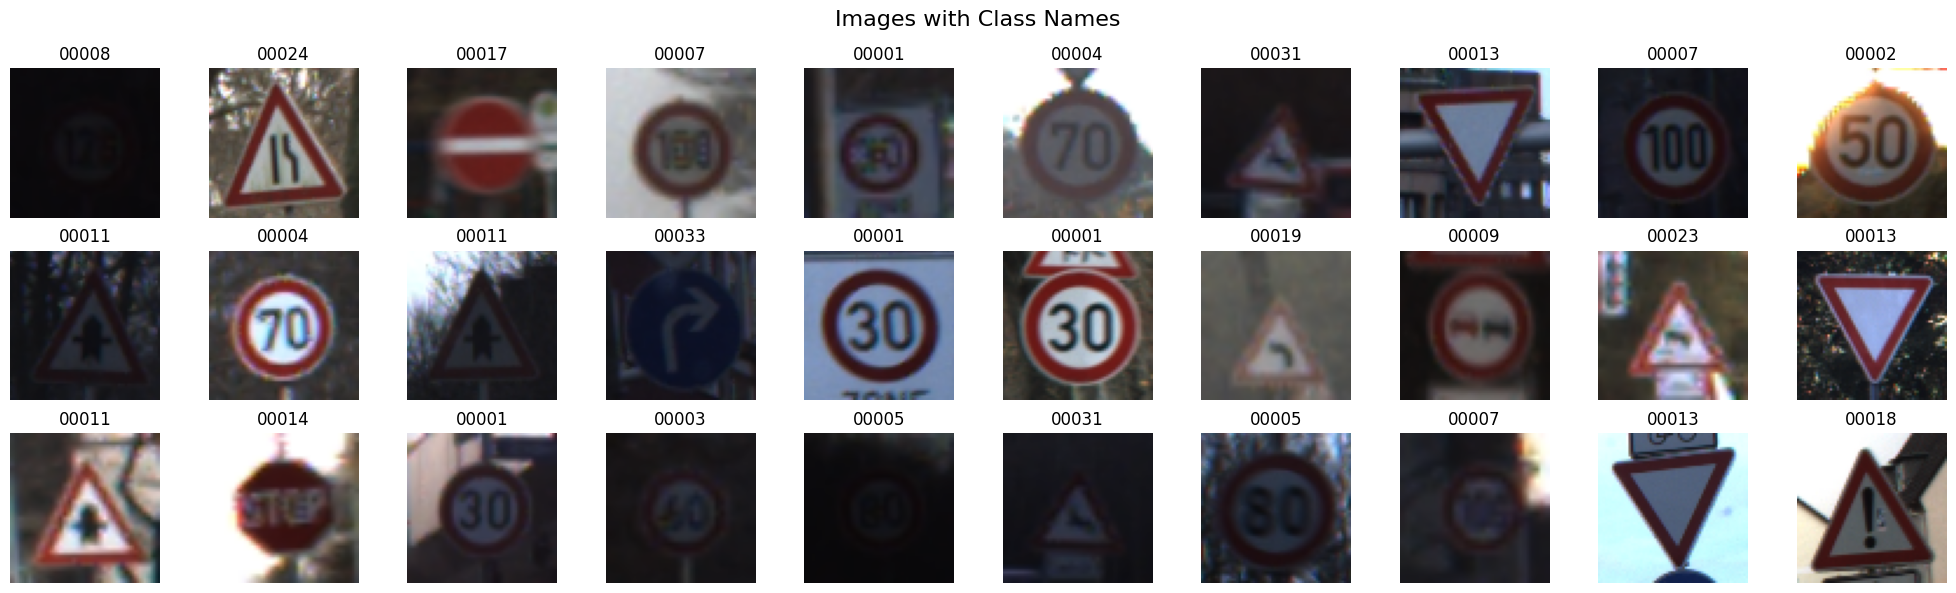

In [32]:
# Function to display images
def display_images(images, labels, class_names, num_rows, num_cols):
    width = 2 * num_rows
    height = 2 * num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(height, width))
    fig.suptitle('Images with Class Names', fontsize=16)

    for i, ax in enumerate(axs.flat):
        img = images[i]
        img = img / 255.0
        class_name = class_names[np.argmax(labels[i])]
        ax.imshow(img)
        ax.set_title(f"{class_name}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

display_images(train_images, train_targets, class_names, 3, 10)

# Modelos

## Modelo provavelmente para apagar

Este código prepara e organiza o conjunto das imagens para treinamento e validação, onde são aplicadas transformações de pré-processamento e técnicas de augmentação. São divididos os dados em conjuntos de treino e validação para um treino eficaz e avaliação do desempenho do modelo.

In [ ]:
# Definindo as transformações para normalizar as imagens, convertê-las para tensores e aplicar augmentação
transform_original = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização para ImageNet
])

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Aplica uma chance aleatória de flip horizontal
    transforms.RandomRotation(10),  # Aplica uma rotação aleatória até 10 graus
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização para ImageNet
])

# Usando a lista de índices filtrados para criar o target_transform
original_dataset = datasets.ImageFolder(root=TRAIN_SET_PATH, transform=transform_original)
augmented_dataset = datasets.ImageFolder(root=TRAIN_SET_PATH, transform=transform)

combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Dividindo o conjunto de dados combinado em treino e validação
train_size = int(0.8 * len(augmented_dataset))  # 80% para treinamento
val_size = len(augmented_dataset) - train_size  # 20% para validação
train_dataset, val_dataset = random_split(augmented_dataset, [train_size, val_size])

# Criando os DataLoaders para treinamento e validação
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Uma maneira para também fazer data augumentation é inverter as imagens horizontalmente ou rodar aleatóriamente. Também dá para normalizar as imagens

In [ ]:
# For the test set
train_images, train_targets = next(iter(train_loader))
print("Train Set:")
print("Batch shape:", train_images.shape)
img_np = train_images.numpy()
img_np = img_np / 2.64  # Isso assume que seus valores originais variam entre -2.117904 e 2.64
img_np = np.clip(img_np, 0, 1)
img_np = np.transpose(img_np, (0, 2, 3, 1))
print("Each image varies between", np.min(img_np), "and", np.max(img_np))
# Putting color channel last so that the image can be displayed
img_np = np.transpose(img_np, (0, 2, 3, 1))
print("Shape after channel transpose:", img_np.shape)
# print("Test set samples:", len(train_loader.dataset))
print("Test set batches:", len(train_loader))

Train Set:
Batch shape: torch.Size([32, 3, 64, 64])
Each image varies between 0.0 and 1.0
Shape after channel transpose: (32, 64, 3, 64)
Test set batches: 982


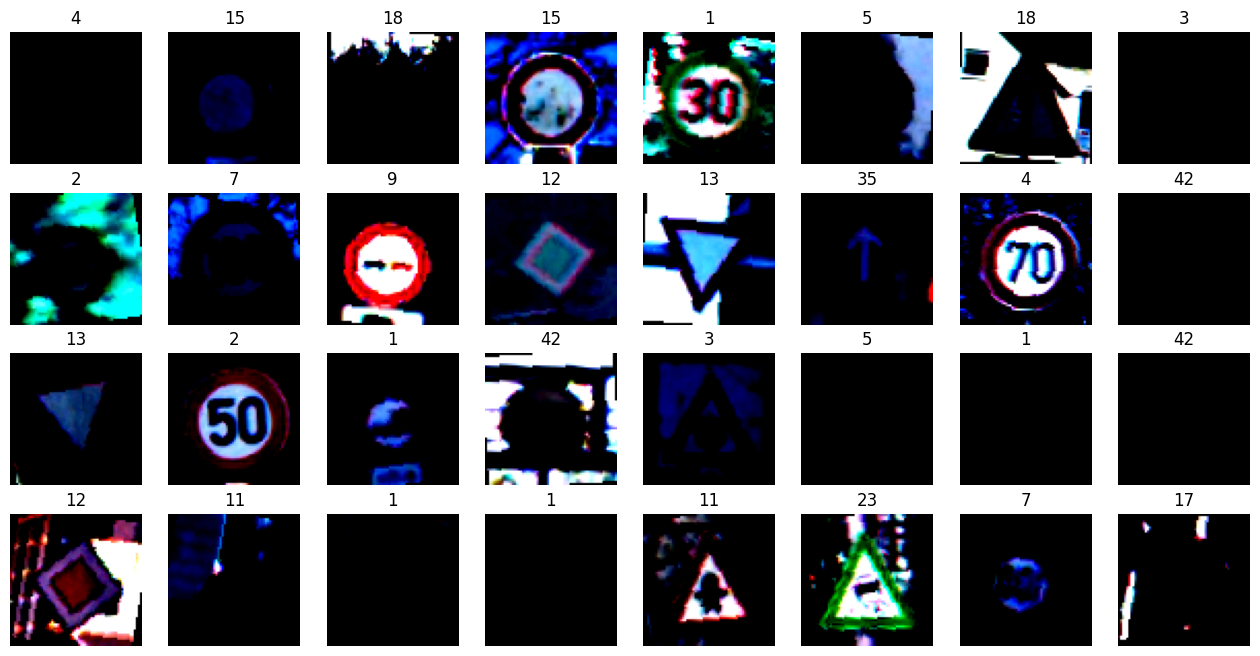

<Figure size 640x480 with 0 Axes>

In [ ]:

# Obter algumas imagens de treinamento para exibição
train_images, train_targets = next(iter(train_loader))
#train_images = np.clip(train_images.numpy(), 0, 1)
vcpi_util.show_images(4,8,train_images, train_targets, train_set.classes)

## CNN

In [54]:
def model_I(classCount, imgSize, channels):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(imgSize, imgSize, channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer added for regularization
    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(classCount, activation='softmax'))

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [55]:
model_I = model_I(NUM_CLASSES, IMG_SIZE, 3)
print(model_I.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 31, 31, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 29, 29, 64)       

In [56]:
for images, labels in train_loader.take(1):
    print(images.shape, labels.shape)

(64, 64, 3) (43,)


In [51]:
file_pathV1 = 'V1'
callbacksV1 = prepare_callbacks(file_pathV1)

historyI = model_I.fit(train_loader, epochs=EPOCHS, validation_data=val_loader, callbacks=callbacksV1)

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(64, 64, 3)


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_I.evaluate(test_images,  test_labels, verbose=2)

NameError: name 'historyI' is not defined

In [ ]:
show_history(historyI)

NameError: name 'show_history' is not defined

In [ ]:
vcpi_util.show_accuracies(train_acc, eval_acc, ['Conv 1', 'Conv 2'])

In [ ]:
def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))

build_confusion_matrix(model_Conv_II, test_loader)

Fazer com mais filtros

## vgg16

De acordo com a documentação oficial do PyTorch, o VGG16 requer um tamanho mínimo de entrada de 32x32 pixels. Embora o VGG16 possa aceitar imagens maiores, como 224x224 pixels, que é o tamanho de entrada padrão para muitos modelos de aprendizado profundo, ele também pode funcionar com imagens menores, como 64x64 pixels. No entanto, o desempenho do modelo pode ser afetado pela diminuição do tamanho da imagem, pois o modelo pode perder informações visuais importantes.

In [ ]:
vgg16 = models.vgg16(pretrained=True)

# Remover a última camada de classificação para ajustar ao seu número de classes
NUM_FEATURES = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]  # Remover a última camada
features.extend([nn.Linear(NUM_FEATURES, NUM_CLASSES)])  # Adicionar a nova camada
vgg16.classifier = nn.Sequential(*features)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg16.to(device)
print(f'device: {device}')

optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

c:\Users\ferna\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ferna\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device: cuda:0


In [ ]:
def train_vgg16_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'accuracy': [], 'loss': []}
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        history['accuracy'].append(accuracy)
        history['loss'].append(running_loss / len(train_loader))

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy}')

        # Avaliação no conjunto de validação
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        accuracy_val = 100 * correct_val / total_val
        print(f'Validation Accuracy: {accuracy_val}')

    return history

In [ ]:
history = train_vgg16_model(vgg16, criterion, optimizer, train_loader, val_loader)

final_accuracy = evaluate(vgg16, val_loader)
print(f'Final Validation Accuracy: {final_accuracy}%')

Epoch 1, Loss: 0.7002421252459865, Accuracy: 78.45187617559856
Validation Accuracy: 95.62611578678909
Epoch 2, Loss: 0.08133800006622582, Accuracy: 97.25507699174291
Validation Accuracy: 98.29125223157358
Epoch 3, Loss: 0.04350058902053616, Accuracy: 98.53349061115185
Validation Accuracy: 98.76307064524356
Epoch 4, Loss: 0.0273620127977577, Accuracy: 99.1455988778015
Validation Accuracy: 98.73756694720734
Epoch 5, Loss: 0.018577064265919107, Accuracy: 99.41977237223834
Validation Accuracy: 99.23488905891354
Epoch 6, Loss: 0.015830065599388682, Accuracy: 99.45802913890394
Validation Accuracy: 98.58454475899005
Epoch 7, Loss: 0.011694710707458596, Accuracy: 99.61424426945516
Validation Accuracy: 99.20938536087732
Epoch 8, Loss: 0.008891419839058752, Accuracy: 99.71626231389678
Validation Accuracy: 99.47717419025759
Epoch 9, Loss: 0.008325642157207061, Accuracy: 99.76089520833997
Validation Accuracy: 99.6557000765111
Epoch 10, Loss: 0.005269053300938077, Accuracy: 99.83422067778238
Valida

## ResNet

In [ ]:
model = models.resnet50(pretrained=True)

NUM_FEATURES = model.fc.in_features
model.fc = nn.Linear(NUM_FEATURES, NUM_CLASSES)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def train_resnet_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'accuracy': [], 'loss': []}
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        history['accuracy'].append(accuracy)
        history['loss'].append(running_loss / len(train_loader))

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy}')

        # Avaliação no conjunto de validação
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        accuracy_val = 100 * correct_val / total_val
        print(f'Validation Accuracy: {accuracy_val}')

    return history

c:\Users\ferna\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ferna/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [07:45<00:00, 220kB/s] 


In [ ]:
history = train_resnet_model(model, criterion, optimizer, train_loader, val_loader)

final_accuracy = evaluate(model, val_loader)
print(f'Final Validation Accuracy: {final_accuracy}%')

Epoch 1, Loss: 0.5951395030138174, Accuracy: 83.53365001434629
Validation Accuracy: 98.02346340219331
Epoch 2, Loss: 0.13466906654660943, Accuracy: 95.67379730289795
Validation Accuracy: 98.1764855904106
Epoch 3, Loss: 0.050011965613053905, Accuracy: 98.37408741671183
Validation Accuracy: 98.90334098444275
Epoch 4, Loss: 0.033968185710446706, Accuracy: 98.91605827780789
Validation Accuracy: 98.76307064524356
Epoch 5, Loss: 0.021308960796102488, Accuracy: 99.32413045557433
Validation Accuracy: 98.89058913542463
Epoch 6, Loss: 0.01544011271793005, Accuracy: 99.48672171390315
Validation Accuracy: 99.01810762560571
Epoch 7, Loss: 0.011817440955167046, Accuracy: 99.62062039723276
Validation Accuracy: 99.57918898240244
Epoch 8, Loss: 0.015959543500683567, Accuracy: 99.46121720279274
Validation Accuracy: 99.38791124713083
Epoch 9, Loss: 0.009461120131570626, Accuracy: 99.71626231389678
Validation Accuracy: 99.43891864320327
Epoch 10, Loss: 0.0076374794312859, Accuracy: 99.78002359167277
Valid

## AlexNet